In [4]:
import os
import math
import requests
import datetime
from datetime import date, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

In [4]:
# Read in mock dataset used during Excel Tool

os.chdir("/Volumes/data1/723 NAVFAC SWAC/4 Working/SWAC Tool Working Files")
df = pd.read_excel("NAVFAC SWAC PMV Model Bare.xlsm", 
              sheetname = "Data Building 23", 
              usecols = np.arange(0,9,1),
             header = 3)

df.set_index("HI Date and Time", inplace = True)

In [70]:
# Strip down dataset to just necessary columns for the tool

def locationStrip(loc):
    strip = df[df["Location"] == loc].groupby(pd.TimeGrouper(freq = "1H")).mean()

    dateList = []
    timeList = []
    for x in strip.reset_index()["HI Date and Time"]:
        dateList.append(x.date())
        timeList.append(x.time())

    strip["HI Date"] = dateList
    strip["HI Time"] = timeList

    strip = strip[(strip["HI Date"] == dates[0]) | (strip["HI Date"] == dates[1]) | 
          (strip["HI Date"] == dates[2]) | (strip["HI Date"] == dates[3]) | 
          (strip["HI Date"] == dates[4]) | (strip["HI Date"] == dates[5])]
    
    strip["Location"] = loc
    strip.reset_index(inplace = True)
    cols = ["Building", "Location", "% of SF", "HI Date and Time", "HI Date", "HI Time", 
            "Water Temperature", "Air Temperature", "Relative Humidity"]
    
    strip = strip[cols]
    return(strip)

B104 = locationStrip("B23-104B")
B210 = locationStrip("B23-210B")
BLC = locationStrip("B23-LC")
strip = pd.concat([B104, B210, BLC], axis = 0)

strip.to_excel("Stripped Building 23 Date.xlsx")

### Database Creation and Upload

In [128]:
#Read in Excel Tool Version 5 to dataframe and format

db = pd.read_excel("NAVFAC SWAC PMV Model 5.0.xlsm", 
              sheetname = "Data Building 23", 
              usecols = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,24,25,26,27],
             header = 3)

# Remove Unncecessary columns from Excel tool raw data
db.drop(["Humidity Ratio", "PMV", "HI Date", "HI Time"], axis = 1, inplace = True)

# Rename columns
db.columns = ['Building', 'Location', 'Sqft Percent', 'HI Date and Time',
              'Water Temperature', 'Air Temperature', 'Relative Humidity',
              'kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
              'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

# Reorder columns
cols = ['HI Date and Time', 'Building', 'Location', 'Sqft Percent', 'Water Temperature', 
 'Air Temperature', 'Relative Humidity','kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
 'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

db = db[cols]


# Set Date/Time Index
db.set_index("HI Date and Time", inplace = True)

# Format date/time index to proper time stamp data type
dateTime = []
for x in db.reset_index()["HI Date and Time"]:
    hold = datetime.datetime.strftime(x, "%Y-%m-%d %H:%M")
    dateTime.append(datetime.datetime.strptime(hold, "%Y-%m-%d %H:%M"))
    
db.reset_index(inplace = True)
db["HI Date and Time"] = dateTime
db.set_index("HI Date and Time", inplace = True)

In [138]:
# Using Psychopg2 create data table
cursor.execute("CREATE TABLE mock_swac (Date_Time timestamp, Building int, Location varchar(25), Sqft_Percent varchar(25), Water_Temperature int, Air_Temperature varchar(25), Relative_Humidity varchar(25), kWh varchar(25), Energy_Cost varchar(25), Base_MRT varchar(25), Base_Air_Speed varchar(25), Base_Metabolic varchar(25), Base_Clo varchar(25), Advanced_MRT varchar(25), Advanced_Air_Speed varchar(25), Advanced_Metabolic varchar(25), Advanced_Clo varchar(25))")
conn.commit()

# Saving Dataframe as csv before push to postgres
db.reset_index().to_csv("SWAC Database.csv", header = False, index = False)
csv = open("SWAC Database.csv", "r")

# Copy CSV to Mock_SWAC data table
cursor.copy_from(csv, 'mock_swac', sep=',')
conn.commit()

## April 13th Fix and Reupload

In [1]:
# Refer to the notes above as to what all the functions below are doing

os.chdir("/Volumes/data1/723 NAVFAC SWAC/4 Working/SWAC Tool Working Files")
db = pd.read_excel("NAVFAC SWAC PMV Model 5.0.xlsm", 
              sheetname = "Data Building 23", 
              usecols = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,17,18,19,20,21],
             header = 3)

db.drop(["HI Date", "HI Time", "PMV.1"], axis = 1, inplace = True)

db.columns = ['Building', 'Location', 'Sqft Percent', 'HI Date and Time',
              'Water Temperature', 'Air Temperature', 'Relative Humidity',
              'kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
              'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

cols = ['HI Date and Time', 'Building', 'Location', 'Sqft Percent', 'Water Temperature', 
 'Air Temperature', 'Relative Humidity','kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
 'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

db = db[cols]

db.set_index("HI Date and Time", inplace = True)

In [49]:
# Change Clothing Insulation value with the data dictionary below

cloChange = {
    1.065: .64,
    2.13: 1.07,
    1.278: .64,
    1.42: .71,
    1.92: .96,
    1.1520000000000001: .58,
    1.28: .64
}

db["Advanced Clo"] = db["Advanced Clo"].apply(lambda x: cloChange[x])

In [9]:
# Set Date/Time Timestamp as index

dateTime = []
for x in db.reset_index()["HI Date and Time"]:
    hold = datetime.datetime.strftime(x, "%Y-%m-%d %H:%M")
    dateTime.append(datetime.datetime.strptime(hold, "%Y-%m-%d %H:%M"))
    
db.reset_index(inplace = True)
db["HI Date and Time"] = dateTime
db.set_index("HI Date and Time", inplace = True)

In [50]:
# cursor.execute("DROP TABLE mock_swac;")
# cursor.execute("CREATE TABLE mock_swac (Date_Time timestamp, Building int, Location varchar(25), Sqft_Percent varchar(25), Water_Temperature int, Air_Temperature varchar(25), Relative_Humidity varchar(25), kWh varchar(25), Energy_Cost varchar(25), Base_MRT varchar(25), Base_Air_Speed varchar(25), Base_Metabolic varchar(25), Base_Clo varchar(25), Advanced_MRT varchar(25), Advanced_Air_Speed varchar(25), Advanced_Metabolic varchar(25), Advanced_Clo varchar(25))")
# conn.commit()

# os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC")
# db.reset_index().to_csv("SWAC Database.csv", header = False, index = False)
# csv = open("SWAC Database.csv", "r")

# cursor.copy_from(csv, 'mock_swac', sep=',')
# conn.commit()

## April 27th Reopen

In [3]:
# Refer to the notes above as to what all the functions below are doing

os.chdir("/Volumes/data1/723 NAVFAC SWAC/4 Working/SWAC Tool Working Files")
db = pd.read_excel("NAVFAC SWAC PMV Model 5.0.xlsm", 
              sheetname = "Data Building 23", 
              usecols = [0,1,2,3,4,5,6,7,8,9,10,12,13,14,15,17,18,19,20,21],
             header = 3)

db.drop(["HI Date", "HI Time", "PMV.1"], axis = 1, inplace = True)

db.columns = ['Building', 'Location', 'Sqft Percent', 'HI Date and Time',
              'Water Temperature', 'Air Temperature', 'Relative Humidity',
              'kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
              'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

cols = ['HI Date and Time', 'Building', 'Location', 'Sqft Percent', 'Water Temperature', 
 'Air Temperature', 'Relative Humidity','kWh', 'Energy Cost', ' Base MRT', 'Base Air Speed','Base Metabolic', 
 'Base Clo','Advanced MRT', 'Advanced Air Speed', 'Advanced Metabolic','Advanced Clo']

db = db[cols]

db.set_index("HI Date and Time", inplace = True)

# Change Clothing Insulation value with the data dictionary below
cloChange = {
    1.065: .64,
    2.13: 1.07,
    1.278: .64,
    1.42: .71,
    1.92: .96,
    1.1520000000000001: .58,
    1.28: .64
}

db["Advanced Clo"] = db["Advanced Clo"].apply(lambda x: cloChange[x])

dateTime = []
for x in db.reset_index()["HI Date and Time"]:
    hold = datetime.datetime.strftime(x, "%Y-%m-%d %H:%M")
    dateTime.append(datetime.datetime.strptime(hold, "%Y-%m-%d %H:%M"))
    
db.reset_index(inplace = True)
db["HI Date and Time"] = dateTime
db.set_index("HI Date and Time", inplace = True)

#### Weather Underground API Call

In [327]:
from datetime import date, timedelta
key = "0bfa64942618d5ec"
site = "IGUAM5"
    
def dateRange(start, end):
    dateRange = []
    date1 = start
    date2 = end

    delta = date2 - date1

    for x in range(delta.days + 1):
        dateRange.append((date1 + timedelta(days = x)).strftime("%Y%m%d"))
    
#     print(list(dateRange))
    

#enter start and end dates in date(Year, Month, Day) format, make sure key and site variables are set
def weatherData(start, end):
    dateRange = []
    date1 = start
    date2 = end

    delta = date2 - date1

    for x in range(delta.days + 1):
        dateRange.append((date1 + timedelta(days = x)).strftime("%Y%m%d"))
        
    data = {}
    
    for date in dateRange:
        urlstart = "http://api.wunderground.com/api/" + str(key) + "/history_"
        urlend = "/q/pws:" + str(site) + ".json"

        url = urlstart + date + urlend

        data[date] = requests.get(url).json()

        
    weatherPretty = []
    weatherYear = []
    weatherMonth = []
    weatherDay = []
    weatherHour = []
    weatherMinute = []
    weatherTemp = []
    weatherHum = []
    weatherRainRate = []

    for x in dateRange:
        for y in range(400):
            try:
                weatherPretty.append(data[x]["history"]["observations"][y]["date"]["pretty"])
                weatherYear.append(data[x]["history"]["observations"][y]["date"]["year"])
                weatherMonth.append(data[x]["history"]["observations"][y]["date"]["mon"])
                weatherDay.append(data[x]["history"]["observations"][y]["date"]["mday"])
                weatherHour.append(data[x]["history"]["observations"][y]["date"]["hour"])
                weatherMinute.append(data[x]["history"]["observations"][y]["date"]["min"])
                weatherTemp.append(data[x]["history"]["observations"][y]["tempi"])
                weatherHum.append(data[x]["history"]["observations"][y]["hum"])
                weatherRainRate.append(data[x]["history"]["observations"][y]["precip_ratei"])
            except:
                break

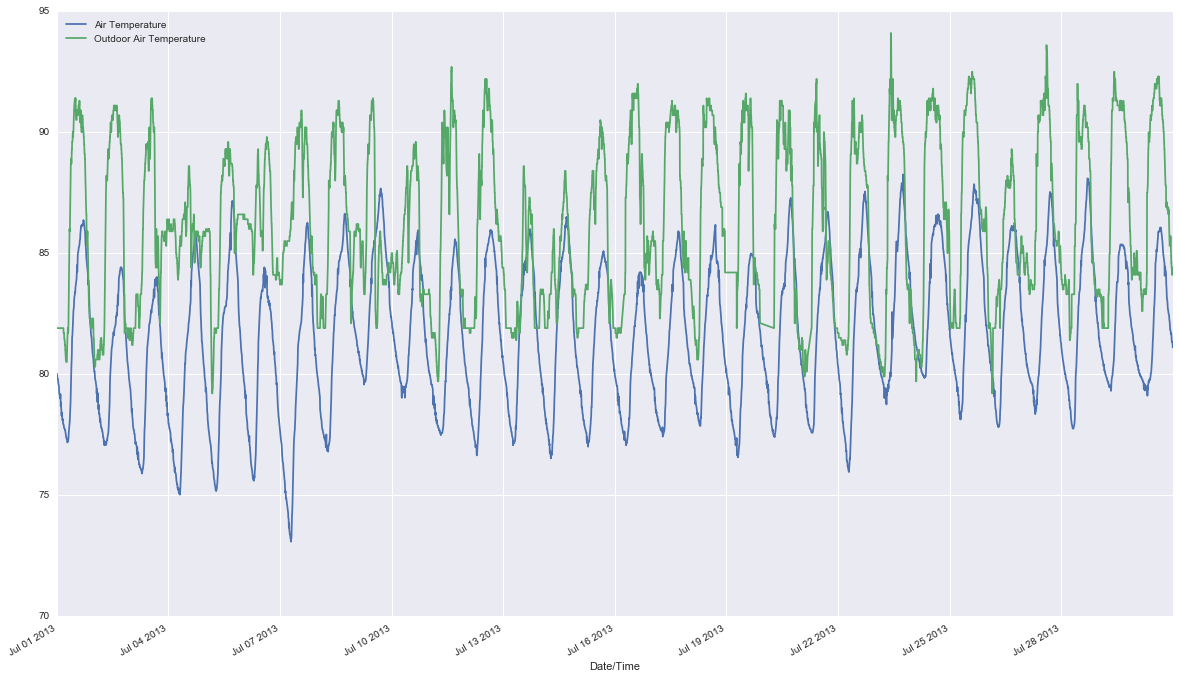

In [71]:
weather = weatherData(date(2016, 7, 1), date(2016, 7, 30))

guamWeather = weather.groupby(pd.TimeGrouper(freq = "5 Min"))[["Temp", "RH%"]].mean().fillna(method = "ffill")
guamWeather.columns = ["Outdoor Air Temperature", "Outdoor Relative Humidity"]
guamWeather.drop(guamWeather[guamWeather["Outdoor Air Temperature"] < 0].index, inplace = True)
guamWeather["Outdoor Air Temperature"] = guamWeather["Outdoor Air Temperature"].apply(lambda x: x + 4)

plt.figure(figsize = (20,12))
db[db["Location"] == "B23-104B"]["Air Temperature"].plot()
guamWeather["Outdoor Air Temperature"].plot()
plt.legend(loc = 0)

In [73]:
# Join Mock Data with Weather Data

db = db.join(guamWeather, how = "left")

db["Outdoor Air Temperature"].fillna(method = 'ffill', inplace = True)
db["Outdoor Relative Humidity"].fillna(method = 'ffill', inplace = True)

In [88]:
# cursor.execute("DROP TABLE mock_swac;")
# cursor.execute("CREATE TABLE mock_swac (Date_Time timestamp, Building int, Location varchar(25), Sqft_Percent varchar(25), Water_Temperature int, Air_Temperature varchar(25), Relative_Humidity varchar(25), kWh varchar(25), Energy_Cost varchar(25), Base_MRT varchar(25), Base_Air_Speed varchar(25), Base_Metabolic varchar(25), Base_Clo varchar(25), Advanced_MRT varchar(25), Advanced_Air_Speed varchar(25), Advanced_Metabolic varchar(25), Advanced_Clo varchar(25), Outdoor_Temp varchar(25), Outdoor_RH varchar(25))")
# conn.commit()

# os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC")
# db.reset_index().to_csv("SWAC Database.csv", header = False, index = False)
# db.to_excel("SWAC Database Clean.xlsx")
# csv = open("SWAC Database.csv", "r")

# cursor.copy_from(csv, 'mock_swac', sep=',')
# conn.commit()

### PMV

In [105]:
#Input Unit of Measure

    # airTemp = Fahrenheit
    # relativeHumidity = Whole Number (eg. 85)
    # Mean Radiant Temp = Fahrenheit
    # airSpeed = Miles per Hour
    # cloValue = Clo
    # metRate = Met

def PMV(airTemp, relativeHum, MRT, airSpeed, cloValue, metRate):
    
    # Returns PMV
    # ta, airTemp, Celcius
    # tr, mean radiant temperature, Celcius
    # vel, relative air velocity, (m/s)
    # rh, relative humidity (%) Used only this way to input humidity level
    # met, metabolic rate, (met)
    # clo, clothing (clo)
    # wme, external work, normally around 0
    
    
    #Conversion of units of measure
    
    ta = (airTemp - 32)/1.8
    tr = (MRT - 32)/1.8
    vel = airSpeed * .44704   
    pa = relativeHum * 10 * math.exp(16.6536 - 4030.183 / (ta + 235))
    
    #Thermal Insulation of the clothing in M2K/W
    
    icl = 0.155 * cloValue
    
    #Metabolic Rate in W/M2
    
    m = metRate * 58.15
    
    #External Work in W/M2
    
    w = .001 * 58.15
    
    #Internal heat production of the human body
    
    mw = m - w
    if icl <= .078:
        fcl = 1 + (1.29 * icl)
    else:
        fcl = 1.05 + (.645 * icl)
    
    #Heat transfer coefficient by forced convection
    
    hcf = 12.1 * np.sqrt(vel)
    taa = ta + 273
    tra = tr + 273
    tcla = taa + (35.5 - ta) / (3.5 * icl + 0.1)
    p1 = icl * fcl
    p2 = p1 * 3.96
    p3 = p1 * 100
    p4 = p1 * taa
    p5 = 308.7 - .028 * mw + p2 * math.pow(tra/100,4)
    xn = tcla / 100
    xf = tcla / 50
    eps = .00015
    
    n = 0
    while (np.abs(xn - xf) > eps):
        xf = (xf + xn) / 2
        hcn = 2.38 * math.pow(np.abs(100 * xf - taa), .25)
        if hcf > hcn:
            hc = hcf
        else:
            hc = hcn
        
        xn = (p5 + p4 * hc - p2 * math.pow(xf,4)) / (100 + p3 * hc)
        
        n+=1
        
        if n > 150:
            print("Max iterations exceeded")
            return 1
    
    tcl = 100 * xn - 273
    
    # Heat loss diff through skin
    
    hl1 = 3.05 * .001 * (5733 - (6.99 * mw) - pa)
    
    # Heat loss by sweating
    
    if mw > 58.15:
        hl2 = .42 * (mw - 58.15)
    else:
        hl2 = 0
    
    # Latent respiration heat loss
    
    hl3 = 1.7 * .00001 * m * (5867 - pa)
    
    # Dry respiration heat loss
    
    hl4 = .0014 * m * (34 - ta)
    
    # Heat loss by radiation
    
    hl5 = 3.96 * fcl * (math.pow(xn, 4) - math.pow(tra/100, 4))
    
    # Heat loss by convection
    
    hl6 = fcl * hc * (tcl - ta)
    
    ts = .303 * np.exp(-0.036 * m) + .028

    pmv = ts * (mw - hl1 - hl2 - hl3 - hl4 - hl5 - hl6)    
    
#     pmv = round(pmv,1)
    
    return(np.round(a = pmv, decimals = 1))

In [156]:
def plotPMV(Location, Water):
    test = db[(db["Location"] == Location) & (db["Water Temperature"] == Water)]
    pmv = []
    for temp, rh, mrt, air, clo, met in zip(test["Air Temperature"], test["Relative Humidity"], test[" Base MRT"], 
                                            test["Base Air Speed"], test["Base Clo"], test["Base Metabolic"]):
        pmv.append(PMV(temp, rh, mrt, air, clo, met))

    holder = pd.DataFrame(test.index.tolist(),
                          columns = ["Date/Time"]).join(pd.DataFrame(pmv, columns = ["PMV"]))

    holder.set_index("Date/Time", inplace = True)

    holder.plot(figsize = (20,12))

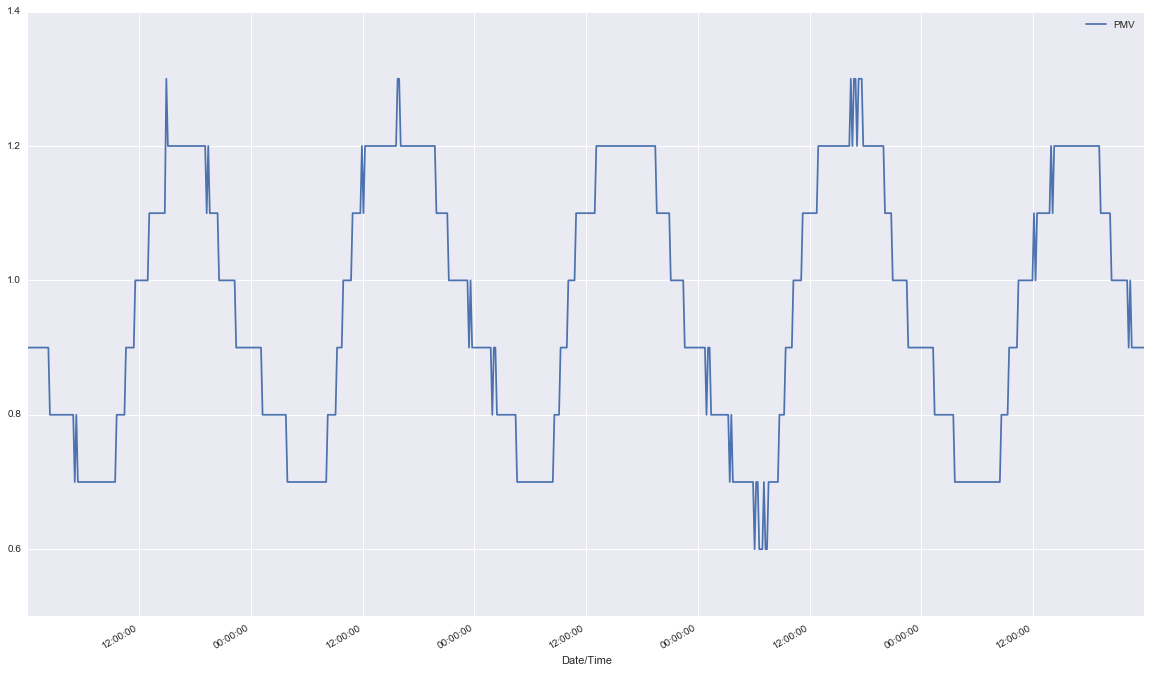

In [159]:
plotPMV("B23-LC", 46)

## May 19th Reopen

In [3]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC")
db = pd.read_excel("SWAC Database Clean.xlsx", index_col = 0)

#### Mock Solar Radiation Data From TMY3

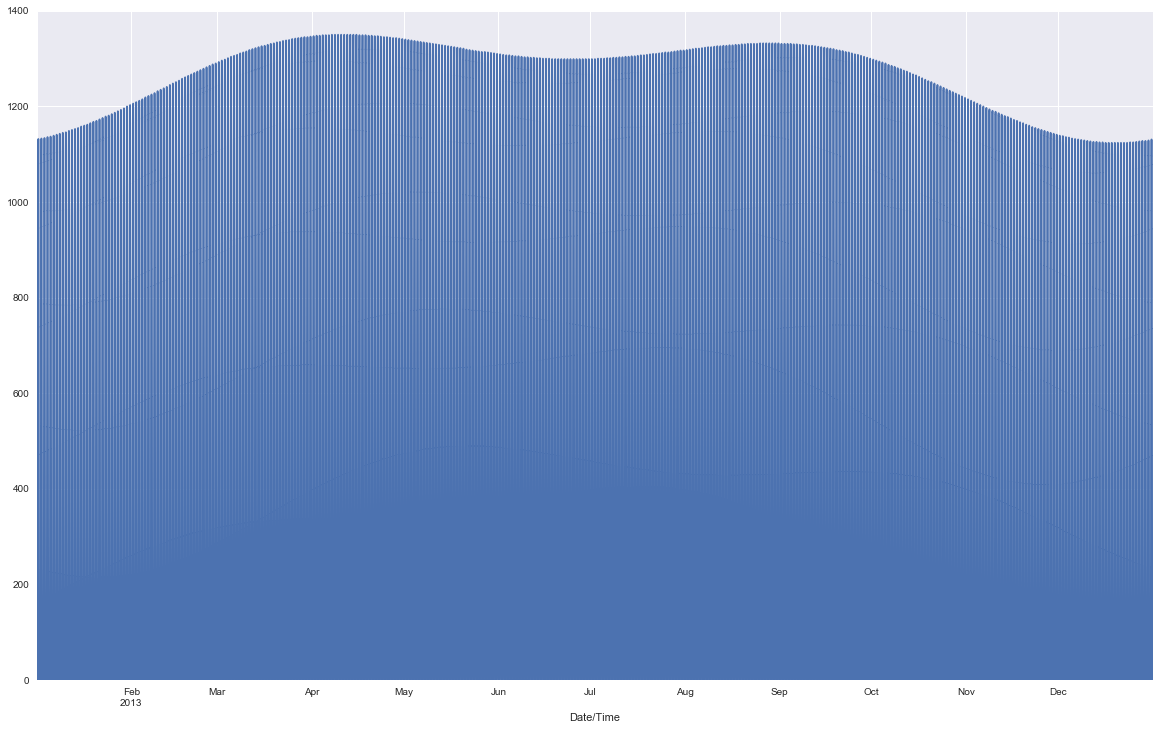

In [295]:
# Pull and Plot Solar Radiation Data

solar = pd.read_csv("912180TY.csv", header =1, usecols = [0,1,2])
solar.columns = ["Date", "Time", "Solar Rad"]

solar = solar[solar["Time"] != '24:00']

dateList = []
timeList = []
dateTimeList = []
for date, time in zip(solar["Date"], solar["Time"]):
    dateList.append(datetime.datetime.strptime(date, "%m/%d/%Y"))
    timeList.append(datetime.datetime.strptime(time, "%H:%M").time())
    dateTimeList.append(datetime.datetime.combine(
        datetime.datetime.strptime(date, "%m/%d/%Y"),
        datetime.datetime.strptime(time, "%H:%M").time()
    ))
    
solar["Date"] = dateList
solar["Time"] = timeList
solar["Date/Time"] = dateTimeList
solar.set_index("Date/Time", inplace = True)

solar["Year"] = solar["Date"].apply(lambda x: x.year)
solar["Month"] = solar["Date"].apply(lambda x: x.month)
solar["Day"] = solar["Date"].apply(lambda x: x.day)

solar = pd.DataFrame(solar.groupby(["Month", "Day", "Time"])["Solar Rad"].mean()).reset_index()

newDateTime = []
for month, day, time in zip(solar["Month"], solar["Day"], solar["Time"]):
    holder = str(month) + "/" + str(day) + "/" + '2013' + " " + str(time)
    newDateTime.append(datetime.datetime.strptime(holder, "%m/%d/%Y %H:%M:%S"))

solar["Date/Time"] = newDateTime
solar.set_index("Date/Time", inplace = True)

solar = solar.groupby(pd.TimeGrouper(freq = "5 Min"))["Solar Rad"].mean().fillna(method = "ffill")

plt.figure(figsize = (20,12))
solar.plot()

solar = pd.DataFrame(solar)

#### Solar Radiation From Weather Underground API

In [403]:
from datetime import date, timedelta
key = "0bfa64942618d5ec"
site = "IGUAM5"
    
#enter start and end dates in date(Year, Month, Day) format, make sure key and site variables are set
def weatherData(start, end):
    dateRange = []
    date1 = start
    date2 = end

    delta = date2 - date1

    for x in range(delta.days + 1):
        dateRange.append((date1 + timedelta(days = x)).strftime("%Y%m%d"))
                
    data = {}
    
    for date in dateRange:
#         print(date)
        urlstart = "http://api.wunderground.com/api/" + str(key) + "/history_"
        urlend = "/q/pws:" + str(site) + ".json"

        url = urlstart + date + urlend

        data[date] = requests.get(url).json()
        
        weatherPretty = []
        weatherYear = []
        weatherMonth = []
        weatherDay = []
        weatherHour = []
        weatherMinute = []
        weatherSolar = []

        for x in dateRange:
            for y in range(400):
                try:
                    weatherPretty.append(data[x]["history"]["observations"][y]["date"]["pretty"])
                    weatherYear.append(data[x]["history"]["observations"][y]["date"]["year"])
                    weatherMonth.append(data[x]["history"]["observations"][y]["date"]["mon"])
                    weatherDay.append(data[x]["history"]["observations"][y]["date"]["mday"])
                    weatherHour.append(data[x]["history"]["observations"][y]["date"]["hour"])
                    weatherMinute.append(data[x]["history"]["observations"][y]["date"]["min"])
                    weatherSolar.append(data[date]["history"]["observations"][y]["solarradiation"])
                except:
                    pass
        
    holder = pd.DataFrame(data = [weatherPretty, weatherYear, weatherMonth, weatherDay, 
                                weatherHour, weatherMinute, weatherSolar]).T

    holder.columns = ["Date/Time", "Year", "Month", "Day", "Hour", "Minute", "Solar Rad"]

    return(holder)

In [437]:
solarWU = weatherData(date(2016,7,1), date(2016,7,30))
solarWU.dropna(inplace = True)
solarWU["Date/Time"] = solarWU["Date/Time"].apply(lambda x: x.replace("ChST on ", ""))

date = []
for y, M, d, h, m in zip(solarWU["Year"], solarWU["Month"], solarWU["Day"], solarWU["Hour"], solarWU["Minute"]):
    holder = str(M) + "/" + str(d) + "/" + str(2013) + " " + str(h) + ":" + str(m)
    date.append(datetime.datetime.strptime(holder, "%m/%d/%Y %H:%M"))

solarWU["Date/Time"] = date

solarWU.set_index("Date/Time", inplace = True)
solarWU["Solar Rad"] = solarWU["Solar Rad"].apply(lambda x: float(x))
solarWU.sort_index(ascending = True, inplace = True)
solarWU = pd.DataFrame(solarWU.groupby(pd.TimeGrouper(freq = "5 Min"))["Solar Rad"].mean().fillna( method = 'ffill'))

db = db.drop("Solar Rad", axis = 1).join(solarWU)

In [465]:
# cursor.execute("DROP TABLE mock_swac;")
# cursor.execute("CREATE TABLE mock_swac (Date_Time timestamp, Building int, Location varchar(25), Sqft_Percent varchar(25), Water_Temperature int, Air_Temperature varchar(25), Relative_Humidity varchar(25), kWh varchar(25), Energy_Cost varchar(25), Base_MRT varchar(25), Base_Air_Speed varchar(25), Base_Metabolic varchar(25), Base_Clo varchar(25), Advanced_MRT varchar(25), Advanced_Air_Speed varchar(25), Advanced_Metabolic varchar(25), Advanced_Clo varchar(25), Outdoor_Temp varchar(25), Outdoor_RH varchar(25), Solar_Rad varchar(25))")
# conn.commit()

# os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC")
# db.reset_index().to_csv("SWAC Database.csv", header = False, index = False)
# db.to_excel("SWAC Database Clean.xlsx")
# csv = open("SWAC Database.csv", "r")

# cursor.copy_from(csv, 'mock_swac', sep=',')
# conn.commit()

# September 8th Final Database Creation

In [2]:
import os
import datetime
from itertools import accumulate
from datetime import date, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import cufflinks as cf
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected = True)
cf.go_offline()

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

### Weather Underground API Call

In [434]:
import requests
key = "0bfa64942618d5ec"
site = "IGUAM5"

#enter start and end dates in date(Year, Month, Day) format, make sure key and site variables are set
def weatherData(start, end):
    dateRange = []
    date1 = start
    date2 = end

    delta = date2 - date1

    for x in range(delta.days + 1):
        dateRange.append((date1 + timedelta(days = x)).strftime("%Y%m%d"))
        
    data = {}
    
    for date in dateRange:
        urlstart = "http://api.wunderground.com/api/" + str(key) + "/history_"
        urlend = "/q/pws:" + str(site) + ".json"

        url = urlstart + date + urlend

        data[date] = requests.get(url).json()

        
    weatherPretty = []
    weatherYear = []
    weatherMonth = []
    weatherDay = []
    weatherHour = []
    weatherMinute = []
    weatherTemp = []
    weatherHum = []
    weatherRainRate = []
    weatherSolar = []

    for x in dateRange:
        for y in range(400):
            try:
                weatherPretty.append(data[x]["history"]["observations"][y]["date"]["pretty"])
                weatherYear.append(data[x]["history"]["observations"][y]["date"]["year"])
                weatherMonth.append(data[x]["history"]["observations"][y]["date"]["mon"])
                weatherDay.append(data[x]["history"]["observations"][y]["date"]["mday"])
                weatherHour.append(data[x]["history"]["observations"][y]["date"]["hour"])
                weatherMinute.append(data[x]["history"]["observations"][y]["date"]["min"])
                weatherTemp.append(data[x]["history"]["observations"][y]["tempi"])
                weatherHum.append(data[x]["history"]["observations"][y]["hum"])
                weatherRainRate.append(data[x]["history"]["observations"][y]["precip_ratei"])
                weatherSolar.append(data[date]["history"]["observations"][y]["solarradiation"])
            except:
                break
    
    
    weatherData = pd.DataFrame(
        data = [weatherYear, weatherMonth, weatherDay, weatherHour, weatherMinute, weatherTemp, weatherHum, weatherRainRate, weatherSolar]
    ).T
    


    weatherData.columns = ["Year","Month", "Day", "Hour", "Minute", "Temp", "RH%", "Rain Rate", "Solar Rad"]
    
    def tryFloat(x):
        try:
            return(float(x))
        except:
            return(x)

    def tryInt(x):
        try:
            return(int(x))
        except:
            return(x)
    

    weatherData["Year"] = weatherData["Year"].apply(lambda x: tryInt(x))    
    weatherData["Month"] = weatherData["Month"].apply(lambda x: tryInt(x))
    weatherData["Day"] = weatherData["Day"].apply(lambda x: tryInt(x))
    weatherData["Hour"] = weatherData["Hour"].apply(lambda x: tryInt(x))
    weatherData["Minute"] = weatherData["Minute"].apply(lambda x: tryInt(x))
    weatherData["Temp"] = weatherData["Temp"].apply(lambda x: tryFloat(x))
    weatherData["RH%"] = weatherData["RH%"].apply(lambda x: tryInt(x))
    weatherData["Rain Rate"] = weatherData["Rain Rate"].apply(lambda x: tryFloat(x))
    weatherData["Solar Rad"] = weatherData["Solar Rad"].apply(lambda x: tryFloat(x))
    

    weatherData["Date/Time"] = pd.to_datetime(weatherData[["Year", "Month", "Day", "Hour", "Minute"]])

    weatherData.set_index("Date/Time", inplace = True)
    
    weatherData = pd.DataFrame(weatherData)
    
    return(weatherData)

In [35]:
# sept2016 = weatherData(date(2016,9,26), date(2016,9,30))
# oct2016 = weatherData(date(2016,10,1), date(2016,10,31))
# nov2016 = weatherData(date(2016,11,1), date(2016,11,30))
# dec2016 = weatherData(date(2016,12,1), date(2016,12,31))

# Creating Dataframe using Weatherundeground dataframe

weatherDF = pd.concat([sept2016, oct2016, nov2016, dec2016], axis = 0)
weatherDF.replace([-9999, -999, -1999.8, -999.9], np.nan, inplace = True)

# Forward Fill to fill null values

weatherDF.fillna(method = "ffill", inplace = True)

# update dataset to 5 minute intervals

weatherDF = weatherDF.groupby(pd.TimeGrouper("5 Min"))[["Temp", "RH%", "Rain Rate", "Solar Rad"]].mean().fillna(method = "ffill")

weatherDF.describe()

# Save Data
os.chdir("/Volumes/data1/723 NAVFAC SWAC/4 Working/SWAC Tool Working Files/Cleaned Analysis Exports ")
weatherDF.to_csv("SWAC Weather Station Cleaned Data.csv")

,Temp,RH%,Rain Rate,Solar Rad
count,27936.000000,27936.000000,27936.000000,27936.000000
mean,87.645323,68.149065,0.019340,98.163123
std,11.205304,30.363220,0.100973,186.969205
min,71.400000,10.000000,0.000000,0.000000
25%,79.700000,68.000000,0.000000,0.000000
50%,82.200000,81.000000,0.000000,0.000000
75%,100.650000,89.000000,0.000000,145.160000
max,112.800000,99.000000,4.890000,920.540000


### Raw Data Processing

<p style = "font-family: Lucida Console; font-size: 15px;"> 
    Lower Commons: Full Dataset from 9/29 to 12/12/16 <br>
    104B: Full Dataset from 9/29 to 12/12/16 <br>
    210B: Full Dataset from 9/29 to 12/12/16 <br>
    Hallway Floor 1: Full Dataset from 9/29 to 12/12/16 <br>
    Hallway Floor 2: Full Dataset from 9/29 to 12/12/16 <br>
</p>

In [268]:
os.chdir("/Volumes/data1/723 NAVFAC SWAC/4 Working/SWAC Tool Working Files/SWAC GUAM/Datalogging Results Analysis")

dfName = {"Bldg_23_Lower_Common_Room": "dfLowerCommon", 
          "Bldg_23_Mid_Hallway_1st_Floor": "dfHallway1", 
          "Bldg_23_Lower_Room_104B": "dfRoom104", 
          "Bldg_23_MidHallway_2nd_Floor": "dfHallway2", 
          "Bldg_23_Upper_Room_210B": "dfRoom104"}

# Read in datasets into dictionary
for location in ["Bldg_23_Lower_Common_Room", "Bldg_23_Mid_Hallway_1st_Floor", "Bldg_23_Lower_Room_104B", 
                 "Bldg_23_MidHallway_2nd_Floor", "Bldg_23_Upper_Room_210B"]:
    
    dfName[location] = pd.read_excel("Bldg_23_1st and 2nd 08102017.xlsx", sheetname = location, 
                  usecols = [1,2,3], header = 1, names = ["Date/Time", "Air Temp", "RH%"])
    
    dfName[location] = dfName[location].set_index("Date/Time").groupby(pd.TimeGrouper(freq = "1H")).mean()
    
    dfName[location].reset_index(inplace = True)
    
# Assign Building and Location to Individual Datasets before concatenation
dfName["Bldg_23_Lower_Common_Room"]["Building"] = 23
dfName["Bldg_23_Lower_Common_Room"]["Location"] = "B23-LC"

dfName["Bldg_23_Lower_Room_104B"]["Building"] = 23
dfName["Bldg_23_Lower_Room_104B"]["Location"] = "B23-104B"

dfName["Bldg_23_Upper_Room_210B"]["Building"] = 23
dfName["Bldg_23_Upper_Room_210B"]["Location"] = "B23-210B"

dfName["Bldg_23_Mid_Hallway_1st_Floor"]["Building"] = 23
dfName["Bldg_23_Mid_Hallway_1st_Floor"]["Location"] = "B23-Hall1"

dfName["Bldg_23_MidHallway_2nd_Floor"]["Building"] = 23
dfName["Bldg_23_MidHallway_2nd_Floor"]["Location"] = "B23-Hall2"

df = pd.concat([dfName["Bldg_23_Lower_Common_Room"], dfName["Bldg_23_Lower_Room_104B"], dfName["Bldg_23_Upper_Room_210B"], 
           dfName["Bldg_23_Mid_Hallway_1st_Floor"], dfName["Bldg_23_MidHallway_2nd_Floor"]], axis = 0)

# Assign Hour for each row for later mergers
df["Hour"] = df["Date/Time"].apply(lambda x: x.hour)

# Set Date/Time as the index for data set
df.set_index("Date/Time", inplace = True)

# Filter data set to just the period of time in which testing is actually happening
df = df.ix["2016-9-29":"2016-12-21"].copy()

# Assign Water Temperature values to the data set
waterTemp = []
for x in df.index.tolist():
    if datetime.datetime(2016, 9, 29) <= x < datetime.datetime(2016, 10, 6):
        waterTemp.append(48)
    elif datetime.datetime(2016, 10, 6) <= x < datetime.datetime(2016, 11, 9):
        waterTemp.append(44)
    elif datetime.datetime(2016, 11, 9) <= x < datetime.datetime(2016, 11, 24):
        waterTemp.append(42)
    elif datetime.datetime(2016, 11, 24) <= x < datetime.datetime(2016, 12, 8):
        waterTemp.append(46)
    elif datetime.datetime(2016, 12, 8) <= x < datetime.datetime(2016, 12, 15):
        waterTemp.append(50)
    elif datetime.datetime(2016, 12, 15) <= x < datetime.datetime(2016, 12, 23):
        waterTemp.append(52)
    else:
        waterTemp.append(np.nan)
    
df["Water Temperature"] = waterTemp

#### Merge In Assumption Values

In [183]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
assumptions = pd.read_excel("Base and Adv Assumptions.xlsx")

# Mean Radiant Temperature Base Value
assumptions["Base MRT"] = round((.9627 * (df["Air Temp"].mean())) + 2.54, 2)

# Merge together the assumptions
df = df.reset_index().merge(assumptions, how = 'left', left_on = ["Hour", "Location"], right_on = ["Hour", "Location"])
df.drop("Hour", axis = 1, inplace = True)

# Add advanced MRT to the dataset
df["Advanced MRT"] = df["Air Temp"].apply(lambda x: round((.9627 * x) + 2.54, 2))

# Set Date/Time as Index again
df.set_index("Date/Time", inplace = True)

## Daily Profile Data For Tableau

In [641]:
daily = df.copy()

# Create Column representing the hour
hour = []
for x in daily.reset_index()["Date/Time"]:
    hour.append(x.time())
daily["Hour"] = hour

# Group by Hour and calculate mean for Air Temp and RH%
daily = daily.groupby(["Location", "Hour"])[["Air Temp", "RH%"]].mean()
daily.reset_index(inplace = True)

# Calculate the average of the hour averages to get daily average
avgDaily = daily.groupby("Hour")[["Air Temp", "RH%"]].mean()
avgDaily["Location"] = "Average"

avgDaily.reset_index(inplace = True)

# Change column names
cols = ["Hour", "Location", "Air Temp", "RH%"]
avgDaily = avgDaily[cols]
daily = daily[cols]

# Concat the two datasets
daily = pd.concat([daily, avgDaily], axis = 0)

# Specify size of plot for tableau visualizations
def avg(x):
    if x == "Average":
        return(1)
    else:
        return(0)
    
daily["Size"] = daily["Location"].apply(lambda x: avg(x))

os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
daily.to_csv("Building 23 Daily Profile by Location.csv", index = False)

#### Recalculate Daily Profile by Chilled Water Temperature

In [649]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
daily23 = pd.read_csv("Building 23 Full Dataset 15Min.csv")

daily23["Date/Time"] = daily23["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# Create column representing the hour
hour = []
for x in daily23["Date/Time"].tolist():
    hour.append(x.hour)
    
daily23["Hour"] = hour

daily23.set_index("Date/Time", inplace = True)
    
# Group by Location, Chilled Water Temperature and Hour then average Air Temperature and Relative Humidity
daily23 = daily23.groupby(["Location", "Water Temperature", "Hour"])[["Air Temperature", "Relative Humidity"]].mean()

daily23.reset_index(inplace = True)

# Calculate Average for each Water Temperature
for x in daily23["Location"].unique().tolist():
    holder = daily23[daily23["Location"] == x].groupby("Hour")[["Air Temperature", "Relative Humidity"]].mean()
    holder["Location"] = x
    holder["Water Temperature"] = "Average"
    holder.reset_index(inplace = True)
    cols = ["Location", "Water Temperature", "Hour", "Air Temperature", "Relative Humidity"]
    daily23 = pd.concat([daily23, holder], axis = 0)
    
# Change "size" for each average for tableau visualization
daily23["Size"] = daily23["Water Temperature"].apply(lambda x: avg(x))

os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
daily23.to_csv("Building 23 Daily Profile by Location and CWT.csv", index = False)

### Daily Profile Building 17

In [740]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/SWAC GUAM/Datalogging Results Analysis")
dfName17 = {
    "Bldg 17 Lower Front office": np.nan,
    "Bldg_17_upper_Rm_205B": np.nan,
    "bldg_17_upper_breakroom": np.nan,
    "Bldg17_lower_rear_hall": np.nan
}

for location in dfName17.keys():
    dfName17[location] = pd.read_excel("Bldg 17 Final Readings Combined.xlsx", sheetname = location, usecols = [1,2,3], 
             names = ["Date/Time", "Air Temp", "RH%"])


dfName17["Bldg 17 Lower Front office"].set_index("Date/Time", inplace = True)
dfName17["Bldg17_lower_rear_hall"].drop_duplicates(inplace = True)
dfName17["Bldg 17 Lower Front office"] = dfName17["Bldg 17 Lower Front office"].groupby(pd.TimeGrouper(freq = "15 Min")).mean()
dfName17["Bldg 17 Lower Front office"].reset_index(inplace = True)

dfName17["Bldg 17 Lower Front office"]["Building"] = 17
dfName17["Bldg 17 Lower Front office"]["Location"] = "B17-LFO"

dfName17["Bldg_17_upper_Rm_205B"].set_index("Date/Time", inplace = True)
dfName17["Bldg17_lower_rear_hall"].drop_duplicates(inplace = True)
dfName17["Bldg_17_upper_Rm_205B"] = dfName17["Bldg_17_upper_Rm_205B"].groupby(pd.TimeGrouper(freq = "15 Min")).mean()
dfName17["Bldg_17_upper_Rm_205B"].reset_index(inplace = True)

dfName17["Bldg_17_upper_Rm_205B"]["Building"] = 17
dfName17["Bldg_17_upper_Rm_205B"]["Location"] = "B17-205B"

dfName17["bldg_17_upper_breakroom"].set_index("Date/Time", inplace = True)
dfName17["Bldg17_lower_rear_hall"].drop_duplicates(inplace = True)
dfName17["bldg_17_upper_breakroom"] = dfName17["bldg_17_upper_breakroom"].groupby(pd.TimeGrouper(freq = "15 Min")).mean()
dfName17["bldg_17_upper_breakroom"].reset_index(inplace = True)

dfName17["bldg_17_upper_breakroom"]["Building"] = 17
dfName17["bldg_17_upper_breakroom"]["Location"] = "B17-BRK"

dfName17["Bldg17_lower_rear_hall"].set_index("Date/Time", inplace = True)
dfName17["Bldg17_lower_rear_hall"].drop_duplicates(inplace = True)
dfName17["Bldg17_lower_rear_hall"] = dfName17["Bldg17_lower_rear_hall"].groupby(pd.TimeGrouper(freq = "15 Min")).mean()
dfName17["Bldg17_lower_rear_hall"].reset_index(inplace = True)

dfName17["Bldg17_lower_rear_hall"]["Building"] = 17
dfName17["Bldg17_lower_rear_hall"]["Location"] = "B17-LRH"



df17 = pd.concat([dfName17["Bldg 17 Lower Front office"], dfName17["Bldg_17_upper_Rm_205B"], 
                  dfName17["bldg_17_upper_breakroom"], dfName17["Bldg17_lower_rear_hall"]], axis = 0)


# daily2 = df17.copy()

# hour = []
# for x in daily2["Date/Time"]:
#     hour.append(x.time())
# daily2["Hour"] = hour

# daily2 = daily2.groupby(["Hour", "Location"]).mean()
# daily2.reset_index(inplace = True)

# avgDaily2 = daily2.groupby("Hour")[["Air Temp", "RH%"]].mean()
# avgDaily2["Location"] = "Average"

# avgDaily2.reset_index(inplace = True)

# cols = ["Hour", "Location", "Air Temp", "RH%"]
# avgDaily2 = avgDaily2[cols]
# daily2 = daily2[cols]

# daily2 = pd.concat([daily2, avgDaily2], axis = 0)

# def avg(x):
#     if x == "Average":
#         return(1)
#     else:
#         return(0)
    
# daily2["Size"] = daily2["Location"].apply(lambda x: avg(x))

# os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
# daily2.to_csv("Building 17 Daily Profile by Location.csv", index = False)

#### Building 17 Merge Outdoor Data

In [444]:
weatherDF2 = weatherData(date(2017, 5, 11), date(2017, 6, 27))

In [448]:
correlation17 = df17.ix["2017-5-11" : "2017-6-27"].join(weatherDF2, how = "inner", rsuffix = "_Outside")

In [454]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
correlation17.to_csv("Building 17 Correlation Dataset.csv")

#### Recalculate Daily Profile by Chilled Water Temperature for Building 17

In [676]:
hour = []
for x in df17["Date/Time"]:
    hour.append(x.hour)
    
df17["Hour"] = hour

df17.set_index("Date/Time", inplace = True)

downstairs17 = df17[(df17["Location"] == "B17-LFO") | (df17["Location"] == "B17-LRH")].copy()
upstairs17 = df17[(df17["Location"] == "B17-BRK") | (df17["Location"] == "B17-205B")].copy()

downstairs17 = downstairs17.ix["2017-4-21" : ].dropna().sort_index().copy()
upstairs17 = upstairs17.ix["2016-6-3" : "2017-6-27"].dropna().sort_index().copy()

full17 = pd.concat([downstairs17, upstairs17], axis = 0)

daily17 = full17.groupby(["Hour", "Location"])[["Air Temp", "RH%"]].mean()

daily17.reset_index(inplace = True)

avgDaily17 = daily17.groupby("Hour")[["Air Temp", "RH%"]].mean()
avgDaily17["Location"] = "Average"

avgDaily17.reset_index(inplace = True)

cols = ["Hour", "Location", "Air Temp", "RH%"]
avgDaily17 = avgDaily17[cols]
daily17 = daily17[cols]

daily17 = pd.concat([daily17, avgDaily17], axis = 0)

def avg(x):
    if x == "Average":
        return(1)
    else:
        return(0)
    
daily17["Size"] = daily17["Location"].apply(lambda x: avg(x))

os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
daily17.to_csv("Building 17 Daily Profile by Location.csv", index = False)

#### Building 17 Merge Outdoor Data Again

In [709]:
# weatherDF3 = weatherData(date(2016, 9, 28), date(2017, 6, 27))
weatherDF3 = weatherDF3[weatherDF3["RH%"] > -1000]
weatherDF3 = weatherDF3.groupby(pd.TimeGrouper(freq = "15 Min"))[["Temp", "RH%", "Rain Rate", "Solar Rad"]].mean()

full17 = full17.join(weatherDF3, how = 'left', rsuffix = "_outside")
full17.sort_index(inplace = True)
full17.dropna(inplace = True)

full17.columns = ["Air Temperature", "Relative Humidity", "Building", "Location", "Hour", "Outdoor Air Temperature", 
                  "Outdoor Relative Humidity", "Rain Rate", "Solar Radiation"]

os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
full17.to_csv("Building 17 Correlation Dataset.csv")

## Building 23 Merge Outdoor Data (Main Dataset)

In [184]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
weatherDF = pd.read_csv("SWAC Weather Station Cleaned Data.csv")

weatherDF["Date/Time"] = weatherDF["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
weatherDF.set_index("Date/Time", inplace = True)
df = df.join(weatherDF[["Temp", "RH%", "Solar Rad"]], how = 'left', rsuffix = "_Outdoor")

#### Calculate Energy Consumption Values and Costs to Dataset

In [185]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/SWAC GUAM/TRACE REPORTS")
energyDF = pd.read_excel("SWAC Trace Energy Summary.xlsx", header = 23, usecols = [2, 3, 5], 
              names = ["Water Temperature", "Energy Consumption (kbtu/year)", "Percentage Change"], 
              skiprows = [0])

dateRange = {
    48: [datetime.datetime(2016, 9, 29), datetime.datetime(2016, 10, 5)],
    44: [datetime.datetime(2016, 10, 6), datetime.datetime(2016, 11, 8)],
    42: [datetime.datetime(2016, 11, 9), datetime.datetime(2016, 11, 23)],
    46: [datetime.datetime(2016, 11, 24), datetime.datetime(2016, 12, 7)],
    50: [datetime.datetime(2016, 12, 8), datetime.datetime(2016, 12, 14)],
    52: [datetime.datetime(2016, 12, 15), datetime.datetime(2016, 12, 21)]
}


def dateAssign(x):
    total = (energyDF[energyDF["Water Temperature"] == x]["Energy Consumption (kbtu/year)"].values) * ((dateRange[x][1] - dateRange[x][0]).days/365)
        
    daily = total / ((dateRange[x][1] - dateRange[x][0]).days)
    
    minutes = daily / 96
    
    # Divide by six locations then convert from kbtu to kwh
    return((minutes[0]/6) * .293)

In [186]:
df["Energy Use"] = df["Water Temperature"].apply(lambda x: dateAssign(x))

# Cost is .295 per kWh
df["Energy Cost"] = df["Energy Use"] * .295

In [188]:
df.columns = ["Air Temperature", "Relative Humidity", "Building", "Location", "Water Temperature", "Base Air Speed", 
              "Base Metabolic", "Base Clo", "Advanced Air Speed", "Advanced Metabolic", "Advanced Clo", "Base MRT", 
              "Advanced MRT", "Outdoor Air Temperature", "Outdoor Relative Humidity", "Solar Rad", "kWh", 
              "Energy Cost"]

col = ["Building", "Location", "Water Temperature", "Air Temperature", "Relative Humidity", "kWh", "Energy Cost", 
       "Base MRT", "Base Air Speed", "Base Metabolic", "Base Clo", "Advanced MRT", "Advanced Air Speed", 
       "Advanced Metabolic", "Advanced Clo", "Outdoor Air Temperature", "Outdoor Relative Humidity", "Solar Rad"]

df = df[col]

In [198]:
df["Air Temperature"].fillna(method = 'ffill', inplace = True)
df["Relative Humidity"].fillna(method = 'ffill', inplace = True)
df["Advanced MRT"].fillna(method = 'ffill', inplace = True)

In [584]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
df.to_csv("Building 23 Full Dataset.csv")

### Reopen and Additional Analysis

In [12]:
# os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
# df = pd.read_csv("Building 23 Full Dataset 15Min.csv")

# df["Date/Time"] = df["Date/Time"].apply(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

# df.set_index("Date/Time", inplace = True)

In [207]:
def analysis(df, location):
    holderDF = pd.DataFrame(index = [42, 44, 46, 48, 50, 52], 
                          columns = ["Location","Both", "Temp", "RH"])
    
    holderDF["Location"] = location
    
    #Both Air Temp and Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp) & (df["Air Temperature"] <= 74) & (df["Air Temperature"] >= 70) & (df["Relative Humidity"] <= 60)])
        den = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp)])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Both", value)
        
    
    # Just Air Temperature
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp) & (df["Air Temperature"] >= 70) & (df["Air Temperature"] <= 74)])
        den = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp)])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Temp", value)
        
    # Just Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp) & (df["Relative Humidity"]  <= 60)])
        den = len(df[(df["Location"] == location) & (df["Water Temperature"] == temp)])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH", value)
    
    print(holderDF)
    print("------")

In [240]:
def analysis2(df):
    holderDF = pd.DataFrame(index = [42, 44, 46, 48, 50, 52], 
                          columns = ["Both", "Temp", "Temp1", "RH", "RH2", "RH3"])
    
    #Both Air Temp and Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Air Temperature"] <= 74) & (df["Air Temperature"] >= 70) & (df["Relative Humidity"] <= 60)])
        den = len(df[df["Water Temperature"] == temp])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Both", value)
        
    
    # Just Air Temperature
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Air Temperature"] >= 70) & (df["Air Temperature"] <= 74)])
        den = len(df[df["Water Temperature"] == temp])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Temp", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Air Temperature"] >= 68) & (df["Air Temperature"] <= 76)])
        den = len(df[df["Water Temperature"] == temp])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Temp1", value)
        
    # Just Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Relative Humidity"]  < 60)])
        den = len(df[df["Water Temperature"] == temp])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Relative Humidity"]  >= 60) & (df["Relative Humidity"]  < 65)])
        den = len(df[df["Water Temperature"] == temp])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH2", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Water Temperature"] == temp) & (df["Relative Humidity"]  >= 65)])
        den = len(df[df["Water Temperature"] == temp])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH3", value)
    
    print(holderDF)
    print("------")

In [241]:
for x in df["Location"].unique().tolist():
    analysis(df, x)

   Location   Both   Temp     RH
42   B23-LC  91.94  91.94    100
44   B23-LC  30.76  40.56  66.67
46   B23-LC  89.58  90.18  95.54
48   B23-LC  83.93  83.93    100
50   B23-LC  89.29  89.29    100
52   B23-LC  89.29  89.29    100
------
    Location   Both   Temp     RH
42  B23-104B    7.2  53.87    7.2
44  B23-104B      0  61.06      0
46  B23-104B  19.14  60.57  19.14
48  B23-104B      0   5.71      0
50  B23-104B  45.14  86.29  45.14
52  B23-104B     48    100     48
------
    Location   Both   Temp     RH
42  B23-210B      0      0      0
44  B23-210B    2.7   4.53  19.98
46  B23-210B      0   1.19      0
48  B23-210B    0.6    0.6  14.88
50  B23-210B      0   2.38      0
52  B23-210B  17.26  35.71  21.43
------
     Location Both   Temp    RH
42  B23-Hall1    0   1.39     0
44  B23-Hall1  8.7  73.65  9.56
46  B23-Hall1    0   2.68     0
48  B23-Hall1    0   5.95     0
50  B23-Hall1    0   7.74     0
52  B23-Hall1    0   5.36     0
------
     Location   Both   Temp     RH
42  B2

In [242]:
analysis2(df)

     Both   Temp  Temp1     RH    RH2    RH3
42  23.14  42.81  85.18   28.1  62.15   9.75
44  11.81   50.7  83.93  24.65  33.23  42.12
46   24.2  45.93  91.38  27.15   62.4  10.45
48  16.88  22.31   77.1  38.37  51.71   9.92
50  30.93  50.06  83.94  35.77   56.2   8.03
52  31.76  56.08  94.21  36.95  49.82  13.22
------


### 2015 Dataset Pull and Analysis

In [218]:
os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/SWAC GUAM/Datalogging Results Analysis")

dfName = {"Bldg_23_Lower_Common_Room": "dfLowerCommon", 
          "Bldg_23_Mid_Hallway_1st_Floor": "dfHallway1", 
          "Bldg_23_Lower_Room_104B": "dfRoom104", 
          "Bldg_23_MidHallway_2nd_Floor": "dfHallway2", 
          "Bldg_23_Upper_Room_210B": "dfRoom104"}

# Read in datasets into dictionary
for location in ["Bldg_23_Lower_Common_Room", "Bldg_23_Mid_Hallway_1st_Floor", "Bldg_23_Lower_Room_104B", 
                 "Bldg_23_MidHallway_2nd_Floor", "Bldg_23_Upper_Room_210B"]:
    
    dfName[location] = pd.read_excel("Bldg_23_1st and 2nd 08102017.xlsx", sheetname = location, 
                  usecols = [1,2,3], header = 1, names = ["Date/Time", "Air Temp", "RH%"])
    
    dfName[location] = dfName[location].set_index("Date/Time").groupby(pd.TimeGrouper(freq = "15 Min")).mean()
    
    dfName[location].reset_index(inplace = True)
    
# Assign Building and Location to Individual Datasets before concatenation
dfName["Bldg_23_Lower_Common_Room"]["Building"] = 23
dfName["Bldg_23_Lower_Common_Room"]["Location"] = "B23-LC"

dfName["Bldg_23_Lower_Room_104B"]["Building"] = 23
dfName["Bldg_23_Lower_Room_104B"]["Location"] = "B23-104B"

dfName["Bldg_23_Upper_Room_210B"]["Building"] = 23
dfName["Bldg_23_Upper_Room_210B"]["Location"] = "B23-210B"

dfName["Bldg_23_Mid_Hallway_1st_Floor"]["Building"] = 23
dfName["Bldg_23_Mid_Hallway_1st_Floor"]["Location"] = "B23-Hall1"

dfName["Bldg_23_MidHallway_2nd_Floor"]["Building"] = 23
dfName["Bldg_23_MidHallway_2nd_Floor"]["Location"] = "B23-Hall2"

df15 = pd.concat([dfName["Bldg_23_Lower_Common_Room"], dfName["Bldg_23_Lower_Room_104B"], dfName["Bldg_23_Upper_Room_210B"], 
           dfName["Bldg_23_Mid_Hallway_1st_Floor"], dfName["Bldg_23_MidHallway_2nd_Floor"]], axis = 0)

df15.set_index("Date/Time", inplace = True)

df15 = df15.ix["2015-9-29":"2015-12-21"].copy()

df15.columns = ["Air Temperature", "Relative Humidity", "Building", "Location"]

In [245]:
def analysis15(df, location):
    holderDF = pd.DataFrame(index = [42, 44, 46, 48, 50, 52], 
                          columns = ["Location","Both", "Temp", "Temp2", "RH", "RH2", "RH3"])
    
    holderDF["Location"] = location
    
    #Both Air Temp and Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Air Temperature"] <= 74) & (df["Air Temperature"] >= 70) & (df["Relative Humidity"] <= 60)])
        den = len(df[df["Location"] == location])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Both", value)
        
    
    # Just Air Temperature
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Air Temperature"] >= 70) & (df["Air Temperature"] <= 74)])
        den = len(df[df["Location"] == location])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Temp", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Air Temperature"] >= 68) & (df["Air Temperature"] <= 76)])
        den = len(df[df["Location"] == location])
    
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "Temp2", value)        
        
    # Just Relative Humidity
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Relative Humidity"]  < 60)])
        den = len(df[df["Location"] == location])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Relative Humidity"]  >= 60) & (df["Relative Humidity"] < 65)])
        den = len(df[df["Location"] == location])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH2", value)
        
    for temp in holderDF.index.tolist():
        num = len(df[(df["Location"] == location) & (df["Relative Humidity"]  >= 65)])
        den = len(df[df["Location"] == location])
        
        value = round(100 * (num/den), 2)
        holderDF.set_value(temp, "RH3", value)
    
    print(holderDF)
    print("------")

In [249]:
df15[df15["Location"] == "B23-210B"]["Air Temperature"].iplot()

In [246]:
for x in df15["Location"].unique().tolist():
    analysis15(df15, x)

   Location Both Temp Temp2     RH   RH2 RH3
42   B23-LC    0    0  0.71  99.99  0.01   0
44   B23-LC    0    0  0.71  99.99  0.01   0
46   B23-LC    0    0  0.71  99.99  0.01   0
48   B23-LC    0    0  0.71  99.99  0.01   0
50   B23-LC    0    0  0.71  99.99  0.01   0
52   B23-LC    0    0  0.71  99.99  0.01   0
------
    Location  Both   Temp  Temp2     RH   RH2   RH3
42  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
44  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
46  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
48  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
50  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
52  B23-104B  27.1  29.04  69.56  97.67  2.15  0.19
------
    Location  Both   Temp  Temp2    RH    RH2    RH3
42  B23-210B  0.69  26.86  56.92  2.94  43.11  10.94
44  B23-210B  0.69  26.86  56.92  2.94  43.11  10.94
46  B23-210B  0.69  26.86  56.92  2.94  43.11  10.94
48  B23-210B  0.69  26.86  56.92  2.94  43.11  10.94
50  B23-210B  0.69  26.86  56.92  2.94  43

In [274]:
# holder = pd.read_clipboard()
# holder.columns = ["Water Temp", "Location", "Both", "Temp", "RH"]
for x in holder["Location"].unique().tolist():
    print(x)
    print("Both Corr", np.corrcoef(holder[holder["Location"] == x]["Water Temp"], holder[holder["Location"] == x]["Both"])[0,1])
    print("Both SD", np.std(holder[holder["Location"] == x]["Both"]))

    print("Temp Corr", np.corrcoef(holder[holder["Location"] == x]["Water Temp"], holder[holder["Location"] == x]["Temp"])[0,1])
    print("Temp SD", np.std(holder[holder["Location"] == x]["Temp"]))

    print("RH Corr", np.corrcoef(holder[holder["Location"] == x]["Water Temp"], holder[holder["Location"] == x]["RH"])[0,1])
    print("RH SD", np.std(holder[holder["Location"] == x]["RH"]))

    print("-------------")


B23-LC
Both Corr 0.351274073457
Both SD 21.7655947286
Temp Corr 0.339846780295
Temp SD 18.1900767361
RH Corr 0.417821213043
RH SD 12.1981315737
-------------
B23-104B
Both Corr 0.784588194243
Both SD 19.9188107633
Temp Corr 0.414116503045
Temp SD 29.6316795564
RH Corr 0.784588194243
RH SD 19.9188107633
-------------
B23-210B
Both Corr 0.614251119831
Both SD 6.25973020363
Temp Corr 0.656687847427
Temp SD 12.7440017481
RH Corr 0.315933222045
RH SD 9.58962706377
-------------
B23-Hall1
Both Corr -0.392792202425
Both SD 3.24229856737
Temp Corr -0.330116520442
Temp SD 25.809358391
RH Corr -0.392792202425
RH SD 3.56280164415
-------------
B23-Hall2
Both Corr -0.493828056501
Both SD 7.25559649895
Temp Corr -0.434480449961
Temp SD 20.1893498464
RH Corr -0.0557435860691
RH SD 20.5706641172
-------------


### Replace Mock Dataset in Postgres

In [199]:
import psycopg2
connect = "user='rh1' password='Anal1st-R0undH0use' host='rds-rh1.4dapt.com' dbname='rh1'"
conn = psycopg2.connect(connect)
cursor = conn.cursor()

cursor.execute("DROP TABLE mock_swac;")
cursor.execute("CREATE TABLE mock_swac (Date_Time timestamp, Building int, Location varchar(25), Water_Temperature int, Air_Temperature varchar(25), Relative_Humidity varchar(25), kWh varchar(25), Energy_Cost varchar(25), Base_MRT varchar(25), Base_Air_Speed varchar(25), Base_Metabolic varchar(25), Base_Clo varchar(25), Advanced_MRT varchar(25), Advanced_Air_Speed varchar(25), Advanced_Metabolic varchar(25), Advanced_Clo varchar(25), Outdoor_Temp varchar(25), Outdoor_RH varchar(25), Solar_Rad varchar(25))")
conn.commit()

os.chdir("/Users/adeniyiharrison/Desktop/723 NAVFAC SWAC/BitBucket/Cleaned Data")
df.reset_index().to_csv("SWAC Database.csv", header = False, index = False)
df.to_csv("Building 23 Full Dataset.csv")
csv = open("SWAC Database.csv", "r")

cursor.copy_from(csv, 'mock_swac', sep=',')
conn.commit()